## Описание проекта

Из банка стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Задача - спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В наличии исторические данные о поведении клиентов и расторжении договоров с банком.

Необходимо построить модель с предельно большим значением F1-меры (не менее 0.59). Проверить F1-меру на тестовой выборке.

Дополнительно измерить AUC-ROC, сравнивая её значение с F1-мерой.

## Инструкция по выполнению проекта

* 		Загрузите и подготовьте данные. Поясните порядок действий.
* 		Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
* 		Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
* 		Проведите финальное тестирование.

## Описание данных

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Признаки

* 		RowNumber — индекс строки в данных
* 		CustomerId — уникальный идентификатор клиента
* 		Surname — фамилия
* 		CreditScore — кредитный рейтинг
* 		Geography — страна проживания
* 		Gender — пол
* 		Age — возраст
* 		Tenure — количество недвижимости у клиента
* 		Balance — баланс на счёте
* 		NumOfProducts — количество продуктов банка, используемых клиентом
* 		HasCrCard — наличие кредитной карты
* 		IsActiveMember — активность клиента
* 		EstimatedSalary — предполагаемая зарплата

## Целевой признак

* 		Exited — факт ухода клиента


===================================================================================================================

# 1. Подготовка данных

In [1]:
# Импортируем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Читаем исходный файл
data = pd.read_csv('/datasets/Churn.csv')

# Смотрим общую информацию
print('INFO')
display(data.info())
print('HEAD 10')
display(data.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

HEAD 10


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


В датасете присутствуют данные, которые не понадобятся нам для построения модели ( столбцы: `RowNumber`, `CustomerID`, `Surname`), так как не влияют на качество будущей модели. Удалим их.

In [2]:
data = data.iloc[:,3:14]

In [3]:
# Проведем оценку данных на пропуски
print("data.isnull():",'\n', data.isnull().sum())

data.isnull(): 
 CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


В столбце `Tenure`(кол-во недвижимости у клиента) наблюдается значительное количество пропусков. В связи с достаточно весомым количеством пропусков, просто удалить такие записи будет расточительно - заменим пропуски медианным значением. Также, тип данных в столбце (float64) неудобочитаем - поменяем на int64.

In [4]:
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
data['Tenure'] = data['Tenure'].astype('int')

In [5]:
# Удостоверимся в изменениях
display(data.info())
print("data.isnull():",'\n', data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


None

data.isnull(): 
 CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Воспользуемся техникой One-Hot Encoding для преобразования категориальных переменных `Geography` и `Gender`

In [6]:
data = pd.get_dummies(data, drop_first=True)

Проверим результат

In [7]:
display(data.info())
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


None

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0
5,645,44,8,113755.78,2,1,0,149756.71,1,0,1,1
6,822,50,7,0.00,2,1,1,10062.80,0,0,0,1
7,376,29,4,115046.74,4,1,0,119346.88,1,1,0,0
8,501,44,4,142051.07,2,0,1,74940.50,0,0,0,1
9,684,27,2,134603.88,1,1,1,71725.73,0,0,0,1


В связи с отсутствием отдельной тестовой выборки, разобъем исходный датасет на 3 части: обучающую (_train), тестовую (_test) и валидационную (_valid), в пропорции 70%/15%/15%, соответственно.

In [8]:
data_train, data_test = train_test_split(data, test_size=0.3, random_state=12345)
data_test, data_valid = train_test_split(data_test, test_size=0.5, random_state=12345)

# Создадим переменные для признаков и целевого признака для каждой из 3 независимых выборок
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

#Проверка размерности выборок
print("Обучающая выборка:", data_train.shape)
print("Тестовая выборка:", data_test.shape)
print("Валидационная выборка:", data_valid.shape)

Обучающая выборка: (7000, 12)
Тестовая выборка: (1500, 12)
Валидационная выборка: (1500, 12)


Теперь выполним масштабирование ряда количественных признаков

In [9]:
col_names = ['CreditScore', 'Tenure', 'Balance', 'Age', 'NumOfProducts', 'EstimatedSalary']
features = data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)    
data[col_names] = features

# 1. Подготовка данных. Выводы.

- исходный датафрейм представлен 10 000 записями по 14 признакам
- наименования столбцов достаточно информативны и стандартизированы
- признаки `RowNumber`, `CustomerId`, `Surname` были удалены в связи с их бесполезностью для обучения модели
- в столбце Tenure(кол-во недвижимости у клиента) наблюдалось значительное количество пропусков (около 9%). Пропуски заменены на медианное значение с целью сохранения объема выборки. Тип данных изменен с float64 на int64, с целью удобочитаемости
- датасет разделили на три независимые выборки:
    - обучающая (70% датасета)
    - тестовая (15% датасета)
    - валидационная (15% датасета)
- проведена нормализация (масштабирование) ряда количественных признаков



# 2. Исследование задачи

### 2.1 Исследование балансов классов

Оценим частоту классов нашего целевого признака (`Exited`)

0    0.7963
1    0.2037
Name: Exited, dtype: float64


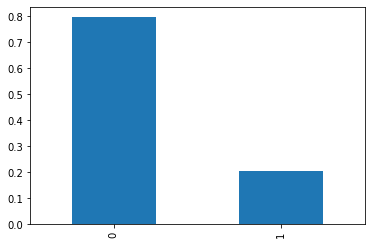

In [10]:
imbalance = data['Exited'].value_counts(normalize=True)
imbalance.plot(kind='bar')
print(imbalance)

Наблюдаем значительный дисбаланс (4:1) в сторону "отрицательного" класса (клиент не расторг договор с банком)

### 2.2 Применение алгоритмов обучения.

#### Обучение модели методом линейного регресса. Алгоритм LogisticRegression.

F1 = 0.036036036036036036
AUC-ROC =  0.6475172466880255


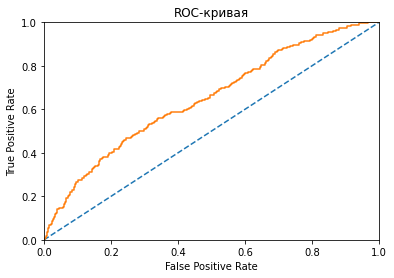

In [11]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)

# Расчет F1 меры
print("F1 =",f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC = ", auc_roc)
#Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Ожидаемо низкие показатели. При дисбалансе классов логистическая регрессия предсказывает плохо.

#### Обучение модели методом Решающее дерево. Алгоритм DecisionTreeClassifier.

In [12]:
# Протестируем значения max_depth от 1 до 20
for depth in range(1, 21, 1):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth = depth)   
    model_dtc.fit(features_train, target_train)
    #Определим предсказания на валидационной выборке
    print("max_depth =", depth, ": ", end='')
    # Рассчитаем F1 меру
    predictions_valid_dtc = model_dtc.predict(features_valid) 
    print("F1 =",f1_score(target_valid, predictions_valid_dtc), ": ", end='')
    probabilities_valid = model_dtc.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("AUC-ROC = ", auc_roc)

max_depth = 1 : F1 = 0.0 : AUC-ROC =  0.6797663634505586
max_depth = 2 : F1 = 0.5071942446043165 : AUC-ROC =  0.7302973676736414
max_depth = 3 : F1 = 0.42505592841163314 : AUC-ROC =  0.796603218673936
max_depth = 4 : F1 = 0.45175438596491224 : AUC-ROC =  0.8176695271792939
max_depth = 5 : F1 = 0.5578747628083492 : AUC-ROC =  0.8464653248004588
max_depth = 6 : F1 = 0.49790794979079506 : AUC-ROC =  0.8445395884153221
max_depth = 7 : F1 = 0.5180722891566265 : AUC-ROC =  0.8143157464451517
max_depth = 8 : F1 = 0.4845995893223819 : AUC-ROC =  0.806854347439474
max_depth = 9 : F1 = 0.5436893203883496 : AUC-ROC =  0.7938015443052088
max_depth = 10 : F1 = 0.5215827338129496 : AUC-ROC =  0.7570984156139928
max_depth = 11 : F1 = 0.5209790209790209 : AUC-ROC =  0.7362603818558737
max_depth = 12 : F1 = 0.5 : AUC-ROC =  0.7183607218790728
max_depth = 13 : F1 = 0.4834437086092716 : AUC-ROC =  0.6984264968585678
max_depth = 14 : F1 = 0.4833333333333333 : AUC-ROC =  0.6795420702396088
max_depth = 15 :

#### Обучение модели методом Случайный лес. Алгоритм RandomForestClassifier.

In [13]:
estim_score  = pd.DataFrame(columns=['estimators', 'max_depth', 'F1', 'AUC_ROC'])

for estim in range(1, 100,2):
    for depth_rfc in range(1,20,1):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators= estim, max_depth = depth_rfc)
        # Обучаем модель
        model_rfc.fit(features_train, target_train)
        # Вычисляем предсказания на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        # Расчет F1 меры
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        f1_rfc = f1_score(target_valid, predictions_valid_rfc)
        probabilities_valid = model_rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)

        estim_score= estim_score.append({'estimators': estim, 'max_depth': depth_rfc, 'F1': f1_rfc , 'AUC_ROC':auc_roc_rfc}, ignore_index=True)

#находим строки с максимальным значением F1
print("Результаты сортировки обученных моделей")
print(estim_score.sort_values(by = 'F1', ascending = False).head())

Результаты сортировки обученных моделей
     estimators  max_depth        F1   AUC_ROC
226        23.0       18.0  0.567515  0.840825
245        25.0       18.0  0.564103  0.839661
169        17.0       18.0  0.562620  0.835151
796        83.0       18.0  0.560636  0.852732
587        61.0       18.0  0.559055  0.849006


# 2. Исследование задачи. Выводы.

- в целевом признаке присутствует дисбаланс 80/20 в сторону "отрицательного" класса (клиент не расторг договор с банком)

Примененные алгоритмы обучения показали следующие результаты:

- Логистическая регрессия. Алгоритм LogisticRegressior. Показал минимальное среди алгоритмов значение F1= 0.036 (AUC_ROC = 0.64)
- Решающее дерево. Алгоритм DecisionTreeClassifier. Показал значение F1= 0.55 (AUC_ROC = 0.84) при максимальной глубине дерева max_depth = 5
- Случайный лес. Алгоритм RandomForestClassifier. Показал максмальное среди всех алгоритмов значение F1= 0.56 (AUC_ROC = 0.84) при максимальной глубине деревьев max_depth = 18 и количеству estimators = 23

Таким образом, на несбалансированых классах, оптмальным для обучения алгоритмом зарекомендовал себя алгоритм Случайный лес.

# 3. Борьба с дисбалансом

Посмотрим как повлияет на эффективность моделей применение двух различных способов:
- взвешивание классов
- увеличение выборки (upsampling)

#### Алгоритм LogisticRegression. Взвешивание классов.

F1 = 0.4758771929824562
AUC-ROC =  0.7336246048325233


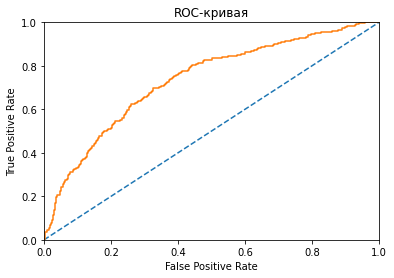

In [14]:
#Применим аргумент class_weight upsampling для балансировки классов
model_lr = LogisticRegression(random_state= 12345, solver='liblinear', class_weight='balanced')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)

# Расчет F1 меры
print("F1 =",f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC = ", auc_roc)
#Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Алгоритм LogisticRegression. Upsampling.

F1 = 0.43912591050988553
AUC-ROC =  0.6992347487252448


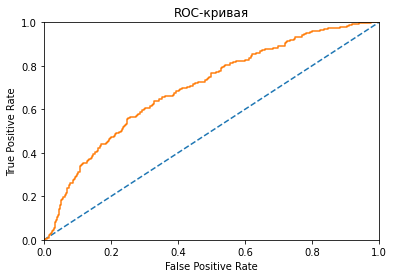

In [15]:
#создадим функцию для применения техники upsampling
def upsample_func(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Вызовем функцию с аргументом repeat = 4, так как "положительный" класс в исходных данных представлен в 4 раза реже чем "отрицательный"
features_upsampled, target_upsampled = upsample_func(features_train, target_train, 4)

model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr.predict(features_valid)

# Расчет F1 меры
print("F1 =",f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC = ", auc_roc)
#Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### Алгоритм DecisionTreeClassifier. Взвешивание классов.

In [16]:
# Протестируем значения max_depth от 1 до 20
for depth in range(1, 21, 1):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')   
    model_dtc.fit(features_train, target_train)
    #Вычсляем предсказания на валидационной выборке
    print("max_depth =", depth, ": ", end='')
# Расчет F1 меры
    predictions_valid_dtc = model_dtc.predict(features_valid) 
    print("F1 =",f1_score(target_valid, predictions_valid_dtc), ": ", end='')
    probabilities_valid = model_dtc.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("AUC-ROC = ", auc_roc)

max_depth = 1 : F1 = 0.4837451235370611 : AUC-ROC =  0.6797663634505586
max_depth = 2 : F1 = 0.5132075471698112 : AUC-ROC =  0.7302973676736414
max_depth = 3 : F1 = 0.5132075471698112 : AUC-ROC =  0.796603218673936
max_depth = 4 : F1 = 0.5312169312169313 : AUC-ROC =  0.8179907044399438
max_depth = 5 : F1 = 0.5815217391304347 : AUC-ROC =  0.8374843061111273
max_depth = 6 : F1 = 0.5759036144578313 : AUC-ROC =  0.8205893204579299
max_depth = 7 : F1 = 0.5745192307692307 : AUC-ROC =  0.8165480611245451
max_depth = 8 : F1 = 0.5587863463969659 : AUC-ROC =  0.8003750607184283
max_depth = 9 : F1 = 0.5562273276904474 : AUC-ROC =  0.7811548578724263
max_depth = 10 : F1 = 0.5360303413400759 : AUC-ROC =  0.7424848502544203
max_depth = 11 : F1 = 0.5365853658536586 : AUC-ROC =  0.7343253552193958
max_depth = 12 : F1 = 0.5204359673024523 : AUC-ROC =  0.7282017524068388
max_depth = 13 : F1 = 0.4936530324400564 : AUC-ROC =  0.7002221697249289
max_depth = 14 : F1 = 0.48153618906942397 : AUC-ROC =  0.6756

#### Алгоритм DecisionTreeClassifier. Upsampling.

In [17]:
# Вызовем функцию с аргументом repeat = 4, так как "положительный" класс в исходных данных представлен в 4 раза реже чем "отрицательный"
features_upsampled, target_upsampled = upsample_func(features_train, target_train, 4)

# Протестируем значения max_depth от 1 до 20
for depth in range(1, 21, 1):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth = depth)   
    model_dtc.fit(features_upsampled, target_upsampled)
    #Определим предсказания на валидационной выборке
    print("max_depth =", depth, ": ", end='')
    # Рассчитаем F1 меру
    predictions_valid_dtc = model_dtc.predict(features_valid) 
    print("F1 =",f1_score(target_valid, predictions_valid_dtc), ": ", end='')
    probabilities_valid = model_dtc.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("AUC-ROC = ", auc_roc)

max_depth = 1 : F1 = 0.4837451235370611 : AUC-ROC =  0.6797663634505586
max_depth = 2 : F1 = 0.5132075471698112 : AUC-ROC =  0.7302973676736414
max_depth = 3 : F1 = 0.5132075471698112 : AUC-ROC =  0.796603218673936
max_depth = 4 : F1 = 0.5312169312169313 : AUC-ROC =  0.8179907044399438
max_depth = 5 : F1 = 0.5815217391304347 : AUC-ROC =  0.8374816517536013
max_depth = 6 : F1 = 0.5759036144578313 : AUC-ROC =  0.8205521594525654
max_depth = 7 : F1 = 0.5745192307692307 : AUC-ROC =  0.8165480611245451
max_depth = 8 : F1 = 0.5551330798479087 : AUC-ROC =  0.7944040834636182
max_depth = 9 : F1 = 0.5538089480048367 : AUC-ROC =  0.7777015387310579
max_depth = 10 : F1 = 0.5316455696202532 : AUC-ROC =  0.7392531699664755
max_depth = 11 : F1 = 0.5482093663911846 : AUC-ROC =  0.7407104122482673
max_depth = 12 : F1 = 0.5191256830601093 : AUC-ROC =  0.727082940709616
max_depth = 13 : F1 = 0.5007032348804501 : AUC-ROC =  0.7042833367397587
max_depth = 14 : F1 = 0.48511904761904767 : AUC-ROC =  0.67824

#### Алгоритм RandomForestClassifier. Взвешивание классов.

In [18]:
estim_score  = pd.DataFrame(columns=['estimators', 'max_depth', 'F1', 'AUC_ROC'])

for estim in range(1, 100,2):
    for depth_rfc in range(1,20,1):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators= estim, max_depth = depth_rfc, class_weight='balanced')
        # Обучаем модель
        model_rfc.fit(features_train, target_train)
        # Вычисляем предсказания на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        # Расчет F1 меры
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        f1_rfc = f1_score(target_valid, predictions_valid_rfc)
        probabilities_valid = model_rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)

        estim_score= estim_score.append({'estimators': estim, 'max_depth': depth_rfc, 'F1': f1_rfc , 'AUC_ROC':auc_roc_rfc}, ignore_index=True)

#находим строки с максимальным значением F1
print("Результаты сортировки обученных моделей")
print(estim_score.sort_values(by = 'F1', ascending = False).head())

Результаты сортировки обученных моделей
     estimators  max_depth        F1   AUC_ROC
462        49.0        7.0  0.627778  0.854499
557        59.0        7.0  0.627558  0.854103
139        15.0        7.0  0.626404  0.849546
899        95.0        7.0  0.626016  0.854018
234        25.0        7.0  0.625869  0.854788


#### Алгоритм RandomForestClassifier. Upsampling.

In [19]:
# Вызовем функцию с аргументом repeat = 4, так как "положительный" класс в исходных данных представлен в 4 раза реже чем "отрицательный"
features_upsampled, target_upsampled = upsample_func(features_train, target_train, 4)

estim_score  = pd.DataFrame(columns=['estimators', 'max_depth', 'F1', 'AUC_ROC'])

for estim in range(1, 100, 2):
    for depth_rfc in range(1,20,1):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators= estim, max_depth = depth_rfc)
        # Обучаем модель
        model_rfc.fit(features_upsampled, target_upsampled)
        # Вычисляем предсказания на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        # Расчет F1 меры
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        f1_rfc = f1_score(target_valid, predictions_valid_rfc)
        probabilities_valid = model_rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)

        estim_score= estim_score.append({'estimators': estim, 'max_depth': depth_rfc, 'F1': f1_rfc , 'AUC_ROC':auc_roc_rfc}, ignore_index=True)

#находим строки с максимальным значением F1
print("Результаты сортировки обученных моделей")
print(estim_score.sort_values(by = 'F1', ascending = False).head())

Результаты сортировки обученных моделей
     estimators  max_depth        F1   AUC_ROC
294        31.0       10.0  0.635854  0.856500
674        71.0       10.0  0.633333  0.856861
408        43.0       10.0  0.632168  0.857618
465        49.0       10.0  0.632022  0.857474
484        51.0       10.0  0.631136  0.857952


# 3. Борьба с дисбалансом. Выводы.

Для устранения дисбаланса классов в обучаемой выборке, на различных алгоритмах обучения, были применены следующие техники:

- взвешивание классов, с использованием дополнительного аргумента class_weight='balanced'
- upsampling

В результате, были получены следующие результаты:

- #### Логистическая регрессия. Алгоритм LogisticRegressior.
    - при взвешивании классов значение F1 увеличилось с `0.036` до `0.47` (значение AUC_ROC  с `0.64` до `0.73`)
    - при upsampling-е значение F1 увеличилось с `0.036` до `0.63` (значение AUC_ROC  с `0.64` до `0.69`)
- #### Решающее дерево. Алгоритм DecisionTreeClassifier.
    - при взвешивании классов значение F1 увеличилось с `0.55` до `0.58` (AUC_ROC снизилось с `0.84` до `0.83`) при максимальной глубине дерева max_depth = 5
    - при upsampling-е значение F1 увеличилось с `0.55` до `0.58` (AUC_ROC снизилось с `0.84` до `0.83`) при максимальной глубине дерева max_depth = 5
- #### Случайный лес. Алгоритм RandomForestClassifier.
    - при взвешивании классов значение F1 увеличилось с `0.56` до `0.62` (AUC_ROC с `0.84` до `0.85`) при максимальной глубине деревьев max_depth = 7 и количеству estimators = 49
    - при upsampling-е значение F1 увеличилось с `0.56` до `0.63` (AUC_ROC с `0.84` до `0.85`) при максимальной глубине деревьев max_depth = 10 и количеству estimators = 31


Применение upsampling-а на алгоритме `RandomForestClassifier` показало наилучший результат в обучении модели, превышающий целевое значение F1 (0.59).

# 4. Тестирование модели

Проверим модель RandomForestClassifier(с применением upsampling-а) на тестовой выборке

F1 = 0.6226138032305434
AUC-ROC =  0.8556099505530361


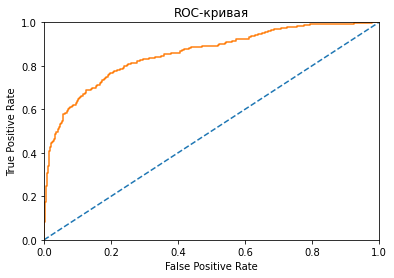

In [20]:
# Вызовем функцию с аргументом repeat = 4, так как "положительный" класс в исходных данных представлен в 4 раза реже чем "отрицательный"
features_upsampled, target_upsampled = upsample_func(features_train, target_train, 4)

model = RandomForestClassifier(random_state=12345, n_estimators= 31, max_depth = 10)
# Обучаем 
model.fit(features_upsampled, target_upsampled)
test_predictions = model.predict(features_test)

# Расчет F1 меры
print("F1 =",f1_score(target_test, test_predictions))
# Расчет AUC-ROC
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC = ", auc_roc)
#Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

# 4. Тестирование модели. Выводы.

В результате применения алгоритма RandomForestClassifier(с применением upsampling-а), при глубине max_depth = 10 и n_estimators= 31, на тестовой выборке были получены значения: F1 = `0.62` и AUC-ROC = `0.85`. Задача по построению модели со значением F1 не ниже `0.59` выполнена.

# Общий вывод.

#### Цель исследования

Предсказать с максимальной точностью уйдёт клиент из банка в ближайшее время или нет

#### Задачи по проекту

- построить модель с предельно большим значением F1-меры > 0.59
- проверить F1-меру на тестовой выборке
- дополнительно измерить AUC-ROC
- сравнить значение AUC-ROC с F1-мерой

#### Общая информация о данных

- в исходном датафрейме представлено 10 000 атрибутов по 14 признакам

#### Результаты исследования

Для обучения модели исходный датасет был разделен на три независимые выборки:

- обучающую (70%)
- тестовую (15%)
- валидационную (15%)

В ходе исследования было осуществлено обучение модели разными алгоритмами:

- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier

Значения F1-меры, во всех случаях, оказались ниже целевой (F1<0.59).

На первом этапе исследования (с использованием разбалансированных классов целевого признака)наиболее эффективным показал себя алгоритм RandomForestClassifier. При помощи перебора в цикле параметров алгоритма удалось достигнутть значение F1= 0.56 (при AUC_ROC = 0.84) при максимальной глубине деревьев max_depth = 18 и количеству estimators = 23.

Так как полученное значение оказалось, по-прежнему, ниже целевого было принято решение о дальнейшем исследовании данных.

В результате исследования установлено, что в целевом признаке присутствует дисбаланс 80/20 в сторону "отрицательного класса" (клиент не расторг договор с банком). Для устранения дисбаланса классов в обучаемой выборке на различных алгоритмах были применены техники балансировки классов:

- взвешивание (с использованием дополнительного аргумента class_weight='balanced')
- upsampling (увеличение выборки)

Применение upsampling-а, на алгоритме RandomForestClassifier, показало наилучший результат в обучении модели(F1 = 0.63 и AUC_ROC = 0.85, при max_depth = 10 и estimators = 31), превышающий целевое значение F1.

На тестовых данных применение обученной с помощью алгоритма RandomForestClassifier модели показало значение F1 = 0.62 при AUC-ROC = 0.85.

Обученная модель удовлетворяет центральной задаче исследования.

===================================================================================================================


#### Спасибо за внимание.
